## import amd setup

In [1]:
import numpy as np
import pyDR as DR
from pyDR.Project import Project
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pickle
import os
from copy import deepcopy

In [2]:
#full_ile_resn = [48, 80, 123, 137, 142, 143, 162, 190, 202, 208, 213, 231, 269]
ile_resn = [3, 13, 23, 30, 36, 44, 61]
#test_list = ["test_001", "test_002", "test_003", "test_010", "test_011", "test_014", "test_015", "test_charm"]
test_list = ["test_001", "test_002", "test_015", "test_003", "test_010", "test_014", "test_011", "test_charm"]
trj_slices = [1,2,3,4]
#color_list = ["lightcoral","firebrick","maroon","darkgreen","cornflowerblue","royalblue","gold"]
color_list = ["#ff5100","#b35348","#ff00e8","#7a0091","#0059ff","#008da5","#7cfe89","#fbdc00"]

In [3]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", color_list)

In [4]:
#dir = "/home/mlehner/pyDR/1ubq_data/"
dir = "/localhome/mlehner/nmr/1ubq/"

In [5]:
data = {}
for test in test_list:
    slice_dict = {}
    for trj_slice in trj_slices:
        resn_dict = {}
        for resn in ile_resn:
            try:
                out=pickle.load(open(f"{dir}{test}/{trj_slice}_{resn}.p","rb"))
                resn_dict[resn] = out
            except:
                print(f"Failed to load {dir}{test}/{trj_slice}_{resn}.p")
        slice_dict[trj_slice] = resn_dict
    data[test] = slice_dict

In [6]:
tf=100000
t=np.arange(tf>>1)*.005

In [7]:
def calc_S2_tc(ct, t):
    S2 = ct.mean(0)[tf>>2:tf>>1].mean()
    b=2*np.argwhere(ct.mean(0)-S2<0)[0,0]
    tc0=t[np.argmin(np.abs((ct.mean(0)[:b]-S2)/(1-S2)-np.exp(-1)))]
    fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum()
    S2,tc=least_squares(fun,[S2,tc0]).x
    return S2, tc

In [8]:
np.vstack([data["test_001"][1][61][0]["ct_finF"][0], data["test_001"][1][61][0]["ct_finF"][1]]).shape

(12, 100001)

In [9]:
def calc_S2_tc_from_multipleCT_with_error(ct, t):
    #ct = np.vstack(ct_list)
    try:
        S2 = ct.mean(0)[tf>>2:tf>>1].mean()
        b=2*np.min([2*np.argwhere(ct.mean(0)-S2<0)[0,0], len(ct.mean(0))//2])
        tc0=t[np.argmin(np.abs((ct.mean(0)[:b]-S2)/(1-S2)-np.exp(-1)))]
        fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum()
        lsq_result = least_squares(fun,[S2,tc0])
        S2,tc=lsq_result.x
        S2_err = np.sqrt(np.diag(lsq_result.jac.T @ lsq_result.jac))[0]
        tc_err = np.sqrt(np.diag(lsq_result.jac.T @ lsq_result.jac))[1]
    except Exception as e:
        print(e)
        return np.nan, np.nan, np.nan, np.nan
    return S2, tc, S2_err, tc_err

In [33]:
from scipy.optimize import lbfgsb

In [83]:
def calc_S2_tc_from_multipleCT_with_error(ct, t):
    S2_list = []
    tc_list = []
    try:
        arrays = np.vsplit(ct, 4)
    except:
        try:
            arrays = np.vsplit(ct, 3)
        except:
            try:
                arrays = np.vsplit(ct, 2)
            except:
                arrays = [ct]
    for ct in arrays:
        try:
            S2 = ct.mean(0)[tf>>2:tf>>1].mean()
            b=np.min([4*np.argwhere(ct.mean(0)-S2<0)[0,0], len(ct.mean(0))//2])
            tc0=t[np.argmin(np.abs((ct.mean(0)[:b]-S2)/(1-S2)-np.exp(-1)))]
            fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum()
            lsq_result = least_squares(fun,[S2,tc0])
            #lsq_result = lbfgsb.fmin_l_bfgs_b(fun,[S2,tc0])
            S2,tc=lsq_result.x
            S2_list.append(S2)
            tc_list.append(tc)
        except Exception as e:
            print(e)
            return np.nan, np.nan, np.nan, np.nan
    S2 = np.mean(S2_list)
    tc = np.mean(tc_list)
    S2_err = np.std(S2_list)
    tc_err = np.std(tc_list)
    return S2, tc, S2_err, tc_err

In [84]:
print(calc_S2_tc(data["test_001"][1][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][2][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][3][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][4][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))

(0.10998137830892106, 0.05882908771122075)
(0.10592408028358016, 0.059645217975735944)
(0.10917684813857684, 0.05874081496186719)
(0.10603770785645168, 0.054624763686081025)


In [85]:
stacked_test001_61 = np.vstack([data["test_001"][i][61][0]["ct_finF"][0] for i in trj_slices])

In [86]:
calc_S2_tc_from_multipleCT_with_error(stacked_test001_61, data["test_001"][1][61][0]["t"])

(0.1040835232263258,
 0.05895614274192555,
 0.0014590437493807156,
 0.002190156000991237)

In [87]:
#data["test_001"][1]

In [88]:
data_stacked_slices = {}
for test in data:
    resn_dict = {}
    for resn in ile_resn:
        motion_dict = {"ct_finF":{}, "t":{}}
        for motion_selector in [0,1,2,3]:
            stacked_slice_temp = None
            try:
                stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices])
            except:
                try:
                    stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices[:-1]])
                except:
                    try:
                        stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices[1:]])
                    except:
                        print(f"Error in {test} {resn}")
            motion_dict["ct_finF"][motion_selector] = stacked_slice_temp
        motion_dict["t"] = data[test][1][resn][0]["t"]
        resn_dict[resn] = motion_dict
    data_stacked_slices[test] = resn_dict

In [89]:
data_stacked_slices["test_001"][61]["ct_finF"][0].shape

(24, 100001)

In [90]:
data_stacked_slices["test_001"][61]["t"].shape

(100001,)

In [91]:
def create_ct_figure(ct_list, title="", legend_str=[""], showFit=True, xrange=None, yrange=None, save=None, show=True):
    fig = plt.figure()
    ax = fig.add_subplot()
    s2_list = []
    tc_list = []
    S2_err_list = []
    tc_err_list = []
    for ct in ct_list:
        ax.plot(t,ct.mean(0)[:tf>>1])
    for ct in ct_list:
        #S2, tc = calc_S2_tc(ct, t)
        S2, tc, S2_err, tc_err = calc_S2_tc_from_multipleCT_with_error(ct, t)
        if showFit:
            ax.plot(t,S2+(1-S2)*np.exp(-t/tc),color='grey',linestyle=':')
        s2_list.append(S2)
        tc_list.append(tc)
        S2_err_list.append(S2_err)
        tc_err_list.append(tc_err)
    if xrange:
        ax.set_xlim(xrange)
    else:
        ax.set_xlim([0,50*np.max(tc_list)])
    if yrange:
        ax.set_ylim(yrange)
    else:
        ax.set_ylim([0,1.05])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("S2")
    #ax.legend([f"{leg_str}, S2={s2:.2f}, tc={tc:.2f}" for s2,tc,leg_str in zip(s2_list,tc_list, legend_str)])
    legend_str = [f"{leg_str}, S2={s2:.3f}±{s2_err:.3f}, tc={tc:.3f}±{tc_err:.4f}" for s2,s2_err,tc,tc_err,leg_str in zip(s2_list,S2_err_list,tc_list,tc_err_list, legend_str)]
    ax.legend(legend_str)
    for leg_str in legend_str:
        print(leg_str)
    ax.set_title(title)
    if save:
        plt.savefig(save)
    fig.show()

ILE61, S2=0.104±0.001, tc=0.029±0.0011
ILE13, S2=0.105±0.002, tc=0.019±0.0003


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


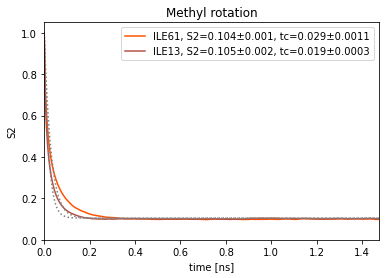

In [92]:
create_ct_figure(ct_list=[data_stacked_slices["test_001"][61]["ct_finF"][0], data_stacked_slices["test_001"][13]["ct_finF"][0]], title="Methyl rotation", legend_str=["ILE61", "ILE13"], showFit=True, xrange=None, yrange=None, save=None, show=True)

ILE61, S2=0.687±0.007, tc=0.370±0.0047
ILE13, S2=0.339±0.039, tc=2.877±0.9457


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


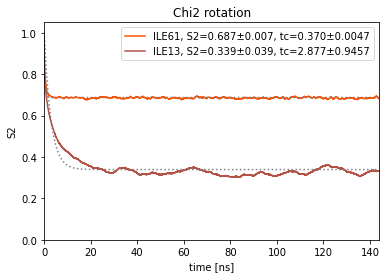

In [93]:
create_ct_figure(ct_list=[data_stacked_slices["test_001"][61]["ct_finF"][1], data_stacked_slices["test_001"][13]["ct_finF"][1]], title="Chi2 rotation", legend_str=["ILE61", "ILE13"], showFit=True, xrange=None, yrange=None, save=None, show=True)

test_001, S2=0.104±0.001, tc=0.029±0.0011
test_002, S2=0.102±0.001, tc=0.006±0.0002
test_015, S2=0.106±0.001, tc=0.029±0.0013
test_003, S2=0.102±0.001, tc=0.007±0.0002
test_010, S2=0.105±0.001, tc=0.033±0.0003
test_014, S2=0.103±0.000, tc=0.007±0.0001
test_011, S2=0.104±0.000, tc=0.031±0.0002
test_charm, S2=0.100±0.002, tc=0.041±0.0009


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


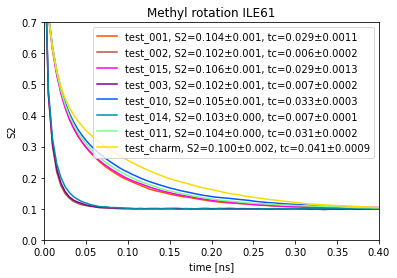

In [94]:
out_data = [data_stacked_slices[test][61]["ct_finF"][0] for test in test_list]
ax = create_ct_figure(out_data, title="Methyl rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,0.4], yrange=[0,0.7], save="../1ubq_data/paris/methylRotationILE61.svg")

test_001, S2=0.687±0.007, tc=0.370±0.0047
test_002, S2=0.722±0.019, tc=0.384±0.0418
test_015, S2=0.727±0.036, tc=0.306±0.0514
test_003, S2=0.689±0.012, tc=0.344±0.0439
test_010, S2=0.620±0.016, tc=0.514±0.0536
test_014, S2=0.604±0.007, tc=0.529±0.0424
test_011, S2=0.680±0.023, tc=0.335±0.0236
test_charm, S2=0.644±0.013, tc=0.128±0.0207


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


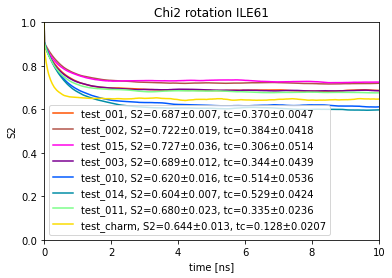

In [95]:
out_data = [data_stacked_slices[test][61]["ct_finF"][1] for test in test_list]
ax = create_ct_figure(out_data, title="Chi2 rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,10], yrange=[0,1], save="../1ubq_data/paris/chi2RotationILE61.svg")

test_001, S2=0.984±0.000, tc=0.005±0.0001
test_002, S2=0.985±0.001, tc=0.005±0.0002
test_015, S2=0.985±0.002, tc=0.005±0.0001
test_003, S2=0.984±0.001, tc=0.006±0.0005
test_010, S2=0.980±0.001, tc=0.007±0.0005
test_014, S2=0.978±0.001, tc=0.006±0.0004
test_011, S2=0.984±0.001, tc=0.006±0.0004
test_charm, S2=0.980±0.001, tc=0.007±0.0017


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


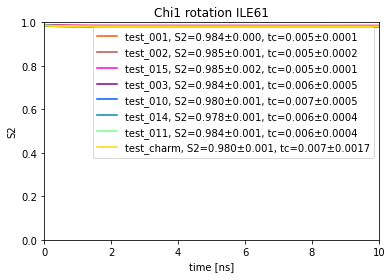

In [96]:
out_data = [data_stacked_slices[test][61]["ct_finF"][2] for test in test_list]
ax = create_ct_figure(out_data, title="Chi1 rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,10], yrange=[0,1], save="../1ubq_data/paris/chi1RotationILE61.svg")

/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:234: RuntimeWarning: overflow encountered in double_scalars
  ratio = actual_reduction / predicted_reduction
/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in square


test_001, S2=0.105±0.002, tc=0.019±0.0003
test_002, S2=0.102±0.001, tc=0.005±0.0000
test_015, S2=0.104±0.000, tc=0.020±0.0001
test_003, S2=0.102±0.001, tc=0.005±0.0001
test_010, S2=0.104±0.000, tc=0.019±0.0003
test_014, S2=0.103±0.000, tc=0.005±0.0000
test_011, S2=0.104±0.001, tc=0.020±0.0001
test_charm, S2=0.101±0.002, tc=0.029±0.0004


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


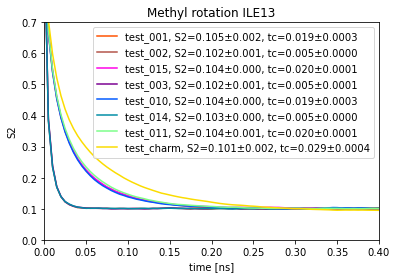

In [97]:
out_data = [data_stacked_slices[test][13]["ct_finF"][0] for test in test_list]
ax = create_ct_figure(out_data, title="Methyl rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,0.4], yrange=[0,0.7], save="../1ubq_data/paris/methylRotationILE13.svg")

test_001, S2=0.339±0.039, tc=2.877±0.9457
test_002, S2=0.418±0.047, tc=3.649±1.4361
test_015, S2=0.291±0.009, tc=4.289±0.2400
test_003, S2=0.349±0.061, tc=2.229±0.2211
test_010, S2=0.316±0.037, tc=2.630±0.5366
test_014, S2=0.357±0.047, tc=3.794±1.3541
test_011, S2=0.447±0.040, tc=2.084±0.2442
test_charm, S2=0.452±0.013, tc=0.499±0.0377


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


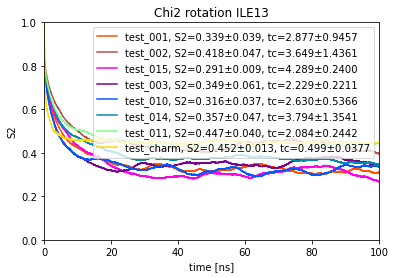

In [98]:
out_data = [data_stacked_slices[test][13]["ct_finF"][1] for test in test_list]
ax = create_ct_figure(out_data, title="Chi2 rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,100], yrange=[0,1], save="../1ubq_data/paris/chi2RotationILE13.svg")

test_001, S2=0.863±0.011, tc=5.067±2.4146
test_002, S2=0.882±0.012, tc=9.655±7.7910
test_015, S2=0.854±0.005, tc=9.522±3.5377
test_003, S2=0.871±0.011, tc=3.607±0.8383
test_010, S2=0.860±0.007, tc=4.236±0.8062
test_014, S2=0.867±0.010, tc=7.844±4.3764
test_011, S2=0.892±0.008, tc=3.429±0.3717
test_charm, S2=0.926±0.007, tc=0.702±0.0792


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


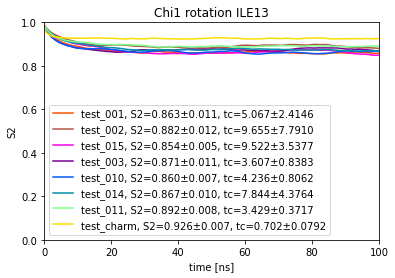

In [99]:
out_data = [data_stacked_slices[test][13]["ct_finF"][2] for test in test_list]
ax = create_ct_figure(out_data, title="Chi1 rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,100], yrange=[0,1], save="../1ubq_data/paris/chi1RotationILE13.svg")

In [100]:
data_stacked_slices["test_001"][61]["ct_finF"][0].shape

(24, 100001)

In [101]:
data_S2_tc = {}
for test in test_list:
    test_dict = {}
    for resn in ile_resn:
        resn_dict = {}
        for motion in [0,1,2,3]:
            S2, tc, S2_err, tc_err = calc_S2_tc_from_multipleCT_with_error(data_stacked_slices[test][resn]["ct_finF"][motion], t)
            resn_dict[motion] = {"S2":S2, "tc":tc, "S2_err":S2_err, "tc_err":tc_err}
        test_dict[resn] = resn_dict
    data_S2_tc[test] = test_dict

/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in square
/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


operands could not be broadcast together with shapes (50000,) (100000,) 
operands could not be broadcast together with shapes (50000,) (100000,) 
operands could not be broadcast together with shapes (50000,) (83960,) 
operands could not be broadcast together with shapes (50000,) (100000,) 
operands could not be broadcast together with shapes (50000,) (100000,) 
operands could not be broadcast together with shapes (50000,) (74236,) 
operands could not be broadcast together with shapes (50000,) (100000,) 
operands could not be broadcast together with shapes (50000,) (68096,) 
operands could not be broadcast together with shapes (50000,) (71564,) 
operands could not be broadcast together with shapes (50000,) (100000,) 


Text(0.5, 1.0, 'Methyl rotation ILE61')

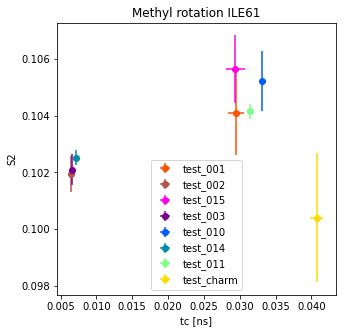

In [102]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][0]["tc"], data_S2_tc[test][61][0]["S2"], xerr=data_S2_tc[test][61][0]["tc_err"], yerr=data_S2_tc[test][61][0]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Methyl rotation ILE61")

Text(0.5, 1.0, 'Chi2 rotation ILE61')

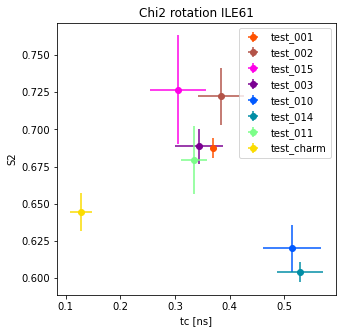

In [104]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][1]["tc"], data_S2_tc[test][61][1]["S2"], xerr=data_S2_tc[test][61][1]["tc_err"], yerr=data_S2_tc[test][61][1]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi2 rotation ILE61")

Text(0.5, 1.0, 'Chi1 rotation ILE61')

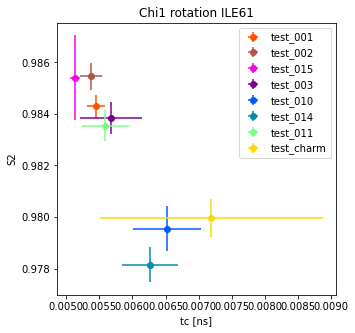

In [105]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][2]["tc"], data_S2_tc[test][61][2]["S2"], xerr=data_S2_tc[test][61][2]["tc_err"], yerr=data_S2_tc[test][61][2]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi1 rotation ILE61")

Text(0.5, 1.0, 'Methyl rotation ILE13')

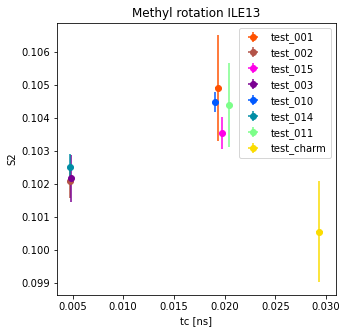

In [106]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][0]["tc"], data_S2_tc[test][13][0]["S2"], xerr=data_S2_tc[test][13][0]["tc_err"], yerr=data_S2_tc[test][13][0]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Methyl rotation ILE13")

Text(0.5, 1.0, 'Chi2 rotation ILE13')

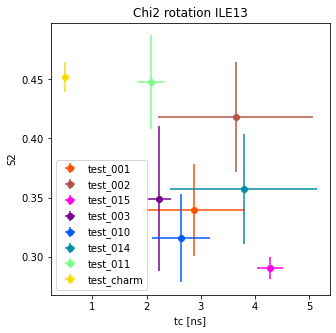

In [107]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][1]["tc"], data_S2 return np.nan, np.nan, np.nan, np._tc[test][13][1]["S2"], xerr=data_S2_tc[test][13][1]["tc_err"], yerr=data_S2_tc[test][13][1]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi2 rotation ILE13")

Text(0.5, 1.0, 'Chi1 rotation ILE13')

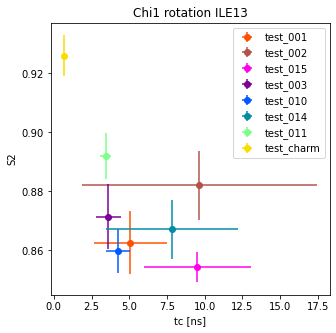

In [108]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][2]["tc"], data_S2_tc[test][13][2]["S2"], xerr=data_S2_tc[test][13][2]["tc_err"], yerr=data_S2_tc[test][13][2]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi1 rotation ILE13")

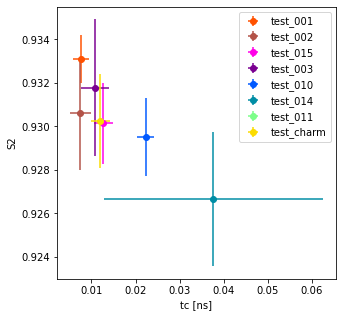

In [109]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][3]["tc"], data_S2_tc[test][61][3]["S2"], xerr=data_S2_tc[test][61][3]["tc_err"], yerr=data_S2_tc[test][61][3]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()

In [110]:
for motion in [0,1,2,3]:
    print(data_S2_tc[test_list[0]][13][motion]["S2"])

0.10490369665745919
0.3391723754712667
0.8626773648889532
0.8631495494520656


In [111]:
# save data_S2_tc as numpy array
np.save("./1ubq_data/1ubq_data_S2_tc_2.npy", data_S2_tc)

In [112]:
data_S2_tc2 = np.load("./1ubq_data/1ubq_data_S2_tc_2.npy", allow_pickle=True).item()

In [113]:
data_S2_tc2

{'test_001': {3: {0: {'S2': 0.10531815874971107,
    'tc': 0.03980174963989863,
    'S2_err': 0.0017906453352257807,
    'tc_err': 0.011621113802819803},
   1: {'S2': 0.6048188635023461,
    'tc': 26.43899607436771,
    'S2_err': 0.4408175883452732,
    'tc_err': 45.78800597793544},
   2: {'S2': 0.9248099318103443,
    'tc': 25.9373839872741,
    'S2_err': 0.117489424179812,
    'tc_err': 44.91748169125399},
   3: {'S2': 0.9384395521457561,
    'tc': 16.795147184418877,
    'S2_err': 0.024950176857332387,
    'tc_err': 29.08104833935}},
  13: {0: {'S2': 0.10490369665745919,
    'tc': 0.019339410580653853,
    'S2_err': 0.0015979386482510372,
    'tc_err': 0.00032768828727297166},
   1: {'S2': 0.3391723754712667,
    'tc': 2.8769698017267125,
    'S2_err': 0.03884365683585254,
    'tc_err': 0.9456962289011436},
   2: {'S2': 0.8626773648889532,
    'tc': 5.067193519819753,
    'S2_err': 0.010586484515259197,
    'tc_err': 2.4146249698127056},
   3: {'S2': 0.8631495494520656,
    'tc': 2.